<a href="https://colab.research.google.com/github/pradeepathota/Gene-Gene-Interaction-Network-Analysis-and-Machine-Learning-Classification-of-BRCA-Samples/blob/main/Gene_Gene_Interactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Expression matrix shape: (20531, 11069)
Phenotype shape: (1247, 193)
          sampleID  label
0  TCGA-3C-AAAU-01      1
1  TCGA-3C-AALI-01      1
2  TCGA-3C-AALJ-01      1
3  TCGA-3C-AALK-01      1
4  TCGA-4H-AAAK-01      1
label
1    1101
0     139
Name: count, dtype: int64
Expression matrix shape: (20531, 1211)
Labels shape: (1211, 2)
Filtered expression matrix shape: (1211, 19077)
Final feature matrix shape: (1211, 0)
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93        23
           1       0.99      1.00      0.99       220

    accuracy                           0.99       243
   macro avg       0.99      0.93      0.96       243
weighted avg       0.99      0.99      0.99       243

ROC AUC Score: 0.9994071146245058


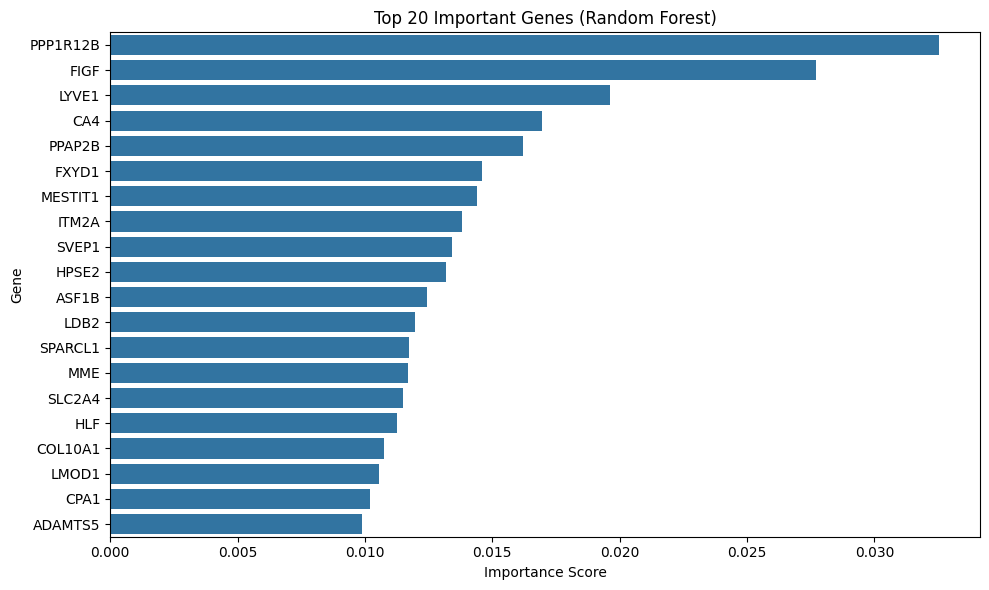

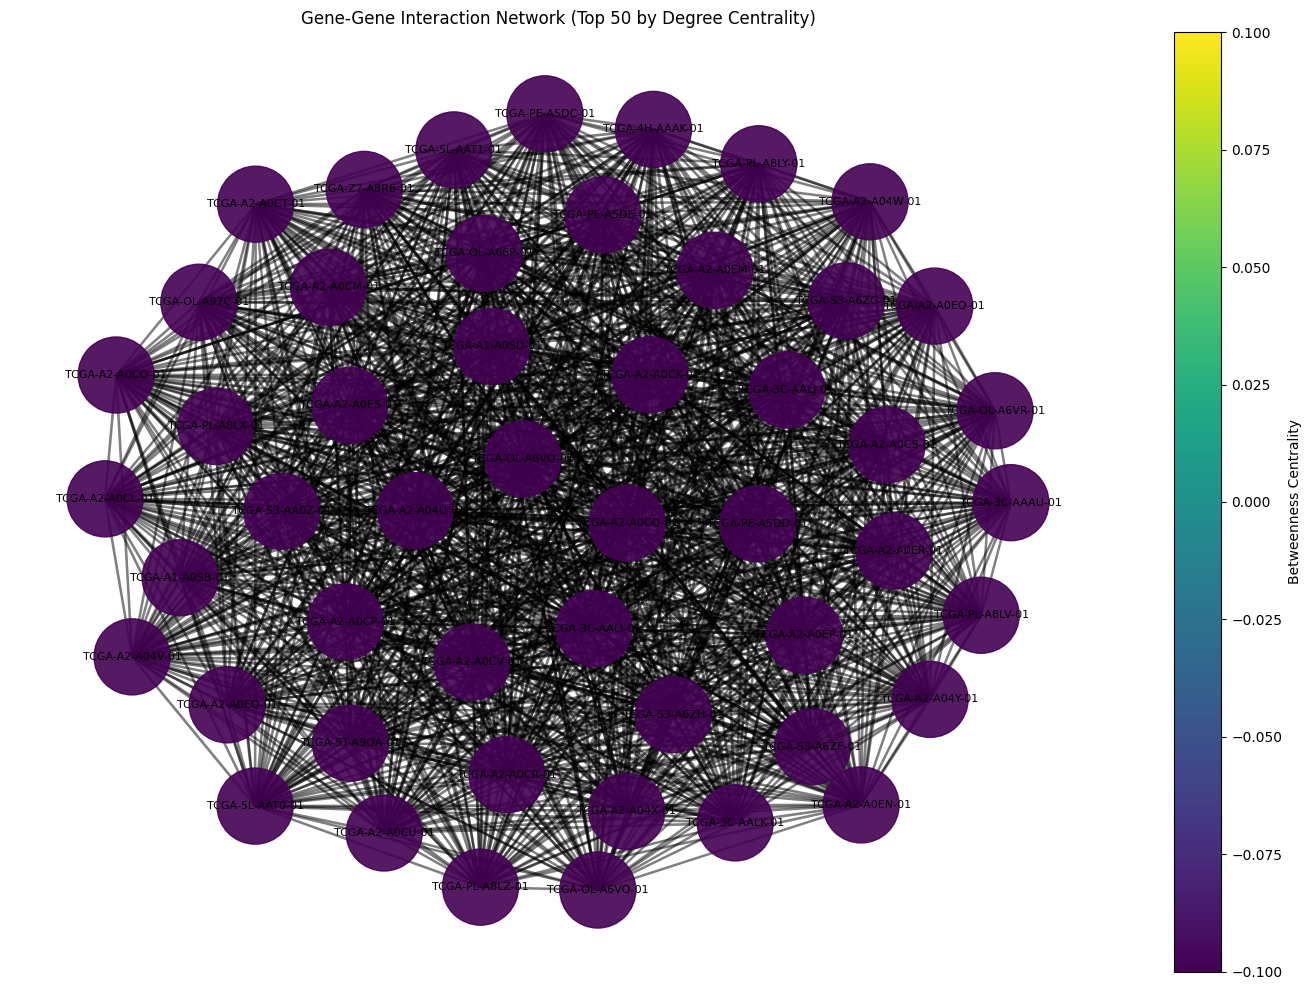

In [4]:
#  Import Libraries
# --------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Step 1: Load Expression & Phenotype
# ---------------------------------------
expr = pd.read_csv("/content/EB++AdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.xena", sep="\t", index_col=0)
pheno = pd.read_csv("/content/TCGA.BRCA.sampleMap-BRCA_clinicalMatrix", sep="\t", index_col=0)
print("Expression matrix shape:", expr.shape)
print("Phenotype shape:", pheno.shape)


# Step 2: Create Tumor vs Normal Labels
# ----------------------------------
labels = pd.DataFrame(pheno.index)
labels.columns = ['sampleID']
labels['label'] = labels['sampleID'].apply(lambda x: 1 if x.endswith('-01') else (0 if x.endswith('-11') else None))
labels = labels.dropna().reset_index(drop=True)
labels['label'] = labels['label'].astype(int)
print(labels.head())
print(labels['label'].value_counts())

# Step 3: Filter BRCA Samples & Align Labels
# -------------------------------------------
expr_brca = expr[expr.columns.intersection(labels['sampleID'])]
labels = labels[labels['sampleID'].isin(expr_brca.columns)]
expr_brca = expr_brca[labels['sampleID'].values]
print("Expression matrix shape:", expr_brca.shape)
print("Labels shape:", labels.shape)
expr_brca.to_csv("expression_matrix.csv")
labels.to_csv("labels.csv", index=False)

# Step 4: Filter Low-Variance Genes
# -----------------------------------
expr = pd.read_csv("expression_matrix.csv", index_col=0)
labels = pd.read_csv("labels.csv")
expr_t = expr.T
selector = VarianceThreshold(threshold=0.1)
filtered_expr = selector.fit_transform(expr_t)
retained_genes = expr_t.columns[selector.get_support()]
filtered_expr_df = pd.DataFrame(filtered_expr, columns=retained_genes, index=expr_t.index)
filtered_expr_df.to_csv("expression_matrix_filtered.csv")
print("Filtered expression matrix shape:", filtered_expr_df.shape)

# Step 5: Build Gene-Gene Correlation Network
# -----------------------------------------
expr = pd.read_csv("expression_matrix_filtered.csv", index_col=0)
corr = expr.T.corr(method='pearson')
threshold = 0.7
edges = corr.stack().reset_index()
edges.columns = ['geneA', 'geneB', 'correlation']
edges = edges[(edges['geneA'] != edges['geneB']) & (edges['correlation'].abs() >= threshold)]
edges.to_csv("ggi_network_edges.csv", index=False)

# Step 6: Compute Network Features
# --------------------------------
edges_df = pd.read_csv("ggi_network_edges.csv")
G = nx.from_pandas_edgelist(edges_df, 'geneA', 'geneB', edge_attr='correlation')
deg_cen = nx.degree_centrality(G)
bet_cen = nx.betweenness_centrality(G)
network_features = pd.DataFrame({
    'gene': list(deg_cen.keys()),
    'degree_centrality': list(deg_cen.values()),
    'betweenness_centrality': list(bet_cen.values())
})
network_features.to_csv("gene_network_features.csv", index=False)

# Step 7: Merge Expression with Network Features
# --------------------------------------------------
expr = pd.read_csv("expression_matrix_filtered.csv", index_col=0)
network_features = pd.read_csv("gene_network_features.csv")
common_genes = expr.columns.intersection(network_features['gene'])
expr_filtered = expr[common_genes]
net_feat_filtered = network_features.set_index('gene').loc[common_genes]
X = expr_filtered.copy()
for col in net_feat_filtered.columns:
    weighted = X * net_feat_filtered[col].values
    weighted.columns = [f"{g}_{col}" for g in weighted.columns]
    X = pd.concat([X, weighted], axis=1)
X.to_csv("X_features.csv")
labels.to_csv("y_labels.csv", index=False)
print("Final feature matrix shape:", X.shape)

# Step 8: Refilter Expression for Modeling
# -----------------------------------------
expression = pd.read_csv("expression_matrix.csv", index_col=0)
labels = pd.read_csv("labels.csv")
valid_samples = list(set(expression.columns) & set(labels['sampleID']))
expression_filtered = expression[valid_samples]
labels_filtered = labels[labels['sampleID'].isin(valid_samples)].reset_index(drop=True)
expression_filtered = expression_filtered.loc[expression_filtered.var(axis=1) > 0.5]
expression_filtered.to_csv("expression_filtered.csv")
labels_filtered.to_csv("labels_filtered.csv", index=False)

# Step 9: Random Forest Classification
# ----------------------------------------
X = pd.read_csv("expression_filtered.csv", index_col=0).T
y = pd.read_csv("labels_filtered.csv").set_index('sampleID').loc[X.index, 'label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Step 10: Feature Importance Plot
# -------------------------------------
importances = pd.Series(clf.feature_importances_, index=X.columns)
top_genes = importances.sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_genes.values, y=top_genes.index)
plt.title("Top 20 Important Genes (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()

# Step 11: Convert Entrez IDs to Gene Symbols
# ---------------------------------------------
expression = pd.read_csv("expression_matrix.csv", index_col=0)
expression.index = expression.index.astype(str).str.strip()
mapping_df = pd.read_csv("/content/hgnc_complete_set.txt", sep="\t", usecols=["entrez_id", "symbol"])
mapping_df.dropna(subset=["entrez_id", "symbol"], inplace=True)
mapping_df["entrez_id"] = mapping_df["entrez_id"].astype(float).astype(int).astype(str)
entrez_to_symbol = dict(zip(mapping_df["entrez_id"], mapping_df["symbol"]))
expression = expression[expression.index.isin(entrez_to_symbol.keys())]
expression.index = expression.index.map(entrez_to_symbol)
expression = expression[~expression.index.duplicated(keep="first")]
expression.to_csv("expression_matrix_genesymbols.csv")

# Step 12: Network Visualization (Top 50)
# ---------------------------------------
edges_df = pd.read_csv("ggi_network_edges.csv")
features_df = pd.read_csv("gene_network_features.csv").set_index("gene")
G = nx.from_pandas_edgelist(edges_df, 'geneA', 'geneB', edge_attr='correlation')
nx.set_node_attributes(G, features_df['degree_centrality'].to_dict(), name='degree')
nx.set_node_attributes(G, features_df['betweenness_centrality'].to_dict(), name='betweenness')
top_nodes = features_df.sort_values("degree_centrality", ascending=False).head(50).index
subG = G.subgraph(top_nodes)
pos = nx.spring_layout(subG, seed=42)
node_sizes = [features_df.loc[n, 'degree_centrality'] * 3000 for n in subG.nodes]
node_colors = [features_df.loc[n, 'betweenness_centrality'] for n in subG.nodes]
edge_widths = [subG[u][v]['correlation'] * 2 for u, v in subG.edges]
fig, ax = plt.subplots(figsize=(14, 10))
nx.draw_networkx_nodes(subG, pos, node_size=node_sizes, node_color=node_colors, cmap='viridis', alpha=0.9, ax=ax)
nx.draw_networkx_edges(subG, pos, width=edge_widths, alpha=0.5, ax=ax)
nx.draw_networkx_labels(subG, pos, font_size=8, ax=ax)
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array(node_colors)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Betweenness Centrality")
ax.set_title("Gene-Gene Interaction Network (Top 50 by Degree Centrality)")
ax.axis('off')
plt.tight_layout()
plt.show()